# RUL Transformer
This notebook creates a Transformer model for RUL prediction of the N-CMAPSS dataset.

In [12]:
import torch
import torch.nn as nn
torch.multiprocessing.set_sharing_strategy('file_system')
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import DataUtils
import Masking

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# device = 'cpu'

In [4]:
batch_size = 64
trainloader, testloader = DataUtils.get_ncmapss_dataloaders(1, n_timesteps=10, batch=batch_size, workers=8, subsampled=True)

In [5]:
columns_excluded = [0, 1, 26] # make sure to mask and THEN take these out
columns_kept = [False, False, True, True, True,
               True, True, True, True, True,
               True, True, True, True, True,
               True, True, True, True, True,
               True, True, True, True, True,
               True, False]
print(columns_kept)

[False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False]


In [6]:
example = next(enumerate(trainloader))
ex_X = example[1][0]
print(ex_X.shape)

ex_y = example[1][1]
print(ex_y.shape)

torch.Size([64, 10, 46])
torch.Size([64, 1])


In [7]:
class RULTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.prediction_window = 1
        self.input_len = 10
        self.n_cols = 46
        self.embed_dim = 64
        
        self.input_projection = nn.Linear(self.input_len*self.n_cols, self.embed_dim)
        self.positional_embed = nn.Parameter(torch.randn(self.embed_dim))
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=self.embed_dim, nhead=4, activation="gelu", dim_feedforward=64)
        self.transformer_blocks = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        
        self.rul_head = nn.Sequential(nn.Linear(self.embed_dim, self.prediction_window))
    
    def forward(self, x):
        
        x = x.flatten(1)
        z = self.input_projection(x)
        z = z + self.positional_embed
        z = self.transformer_blocks(z)
        z = self.rul_head(z)
        
        return z.squeeze(1)

In [8]:
rul_tran = RULTransformer()

In [9]:
rul_tran(ex_X.float())

tensor([-0.6602, -0.8599, -0.5826, -0.7091, -0.6514, -0.6950, -0.7208, -0.6384,
        -0.6164, -0.8447, -0.6123, -0.6516, -0.7612, -0.6479, -0.6070, -0.8839,
        -0.6904, -0.7124, -0.5523, -0.5935, -0.8223, -0.7411, -0.4853, -0.7966,
        -0.5864, -0.7100, -0.7097, -0.6759, -0.6594, -0.7104, -0.7191, -0.7260,
        -0.6923, -0.6812, -0.6524, -0.6917, -0.6609, -0.6492, -0.6419, -0.7585,
        -0.5967, -0.6901, -0.6331, -0.5808, -0.6850, -0.5718, -0.6555, -0.7320,
        -0.6063, -0.7285, -0.7159, -0.5328, -0.7091, -0.7091, -0.5354, -0.7238,
        -0.6538, -0.7413, -0.5468, -0.6633, -0.5858, -0.6457, -0.6696, -0.7300],
       grad_fn=<SqueezeBackward1>)

In [10]:
objective = nn.MSELoss()

rul_tran = RULTransformer().to(device)

lr = 1e-4
n_epochs = 5
optim = torch.optim.Adam(rul_tran.parameters(), lr=lr)
losses = []

for n in range(n_epochs):
    counter = 0
    for i, (X, y) in enumerate(tqdm(trainloader)):
        X = X.to(device)
        y = y.to(device)
        optim.zero_grad()
        yhat = rul_tran(X.float())
        loss = objective(yhat, y.float().squeeze(1))
        loss.backward()
        losses.append(loss.cpu().detach().numpy())
        optim.step()
        counter += 1
        
    print("Epoch:", n+1, "Loss:",np.mean(losses[-counter:][0]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7667/7667 [01:03<00:00, 120.90it/s]


Epoch: 1 Loss: 2992.2246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7667/7667 [01:06<00:00, 115.82it/s]


Epoch: 2 Loss: 7.3410697


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7667/7667 [01:06<00:00, 115.81it/s]


Epoch: 3 Loss: 0.38629562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7667/7667 [01:06<00:00, 115.21it/s]


Epoch: 4 Loss: 0.53664076


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7667/7667 [01:06<00:00, 114.89it/s]

Epoch: 5 Loss: 0.2848695


In [33]:
test_mses = []
yhats = []
ys = []
with torch.no_grad():
    for i, (X, y) in enumerate(tqdm(testloader)):
            yhat = rul_tran(X.float().to(device))
            yhats.append(yhat.cpu())
            ys.append(y.cpu())
            test_mse = objective(yhat, y.float().to(device))
            test_mses.append(test_mse.item())
print("Test MSE:", np.mean(test_mses))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4274/4274 [01:09<00:00, 61.22it/s]

Test MSE: 21.654083743475283


In [73]:
print("Test RMSE: {}".format(np.sqrt(np.mean(test_mses))))

Test RMSE: 4.653394862192041


In [34]:
yhats[0]

tensor([87.8181, 90.1070, 90.1668, 85.7617, 87.8534, 85.9234, 78.7998, 81.8242,
        80.2163, 81.9027, 79.3152, 80.6301, 78.0894, 81.9685, 80.7617, 79.4790,
        80.8484, 81.3401, 81.9267, 81.7620, 79.6719, 81.3664, 77.6123, 81.5965,
        79.8655, 81.1705, 78.6161, 80.5595, 80.0304, 80.8133, 81.9747, 81.1090,
        80.7449, 81.4495, 81.4550, 81.1991, 78.7840, 79.6690, 82.5944, 79.8412,
        80.5711, 80.3498, 81.7627, 82.9278, 79.8233, 80.2133, 77.6328, 79.2136,
        81.1448, 78.7608, 80.6148, 80.5948, 81.6038, 82.7850, 79.8262, 80.0817,
        81.1846, 80.1268, 81.0829, 80.7015, 80.5058, 77.6552, 78.9494, 79.5693])

In [38]:
yhats[0].shape

torch.Size([64])

In [40]:
yhats = torch.cat(yhats)
ys = torch.cat(ys)

In [43]:
def moving_average(data, window_size):
    window = np.ones(window_size) / float(window_size)
    return np.convolve(data, window, 'same')

In [ ]:
smooth_yhats = moving_average(yhats, 10)

In [63]:
def find_splits(y_data):
    splits = [0]
    for i in range(1, len(y_data)):
        if y_data[i-1] == 0 and y_data[i] != 0:
            splits.append(i)
            
    splits.append(len(y_data))
    return splits

In [64]:
split_idx = find_splits(ys)

In [65]:
split_idx

[0, 39259, 119288, 154457, 273523]

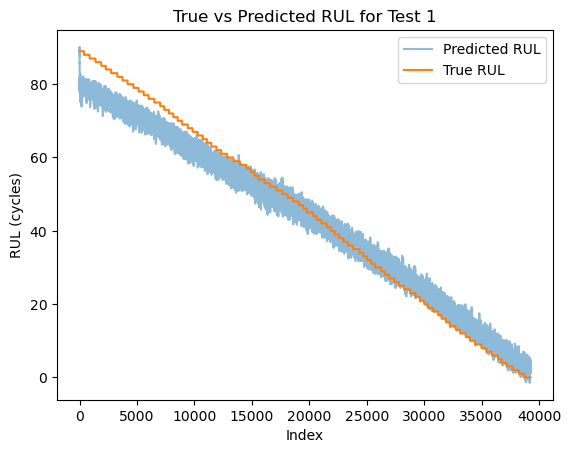

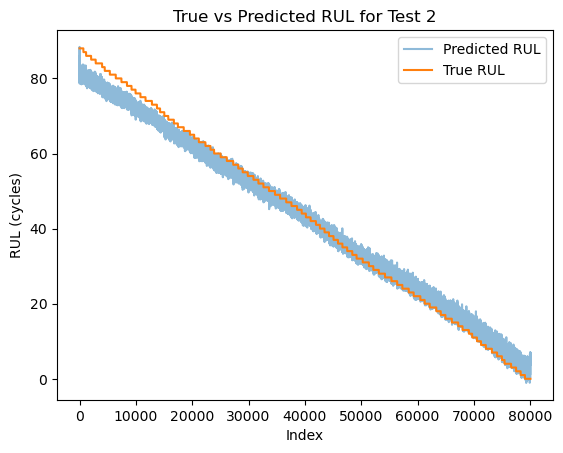

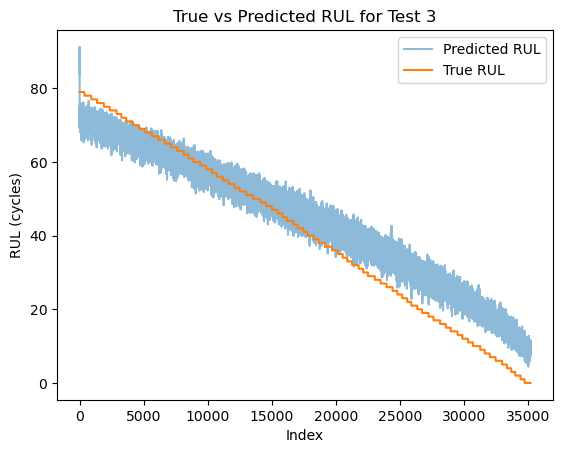

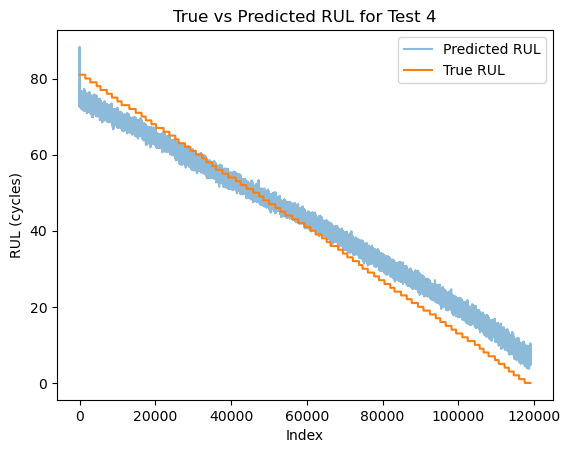

In [68]:
for i in range(len(split_idx)-1):
    plt.title("True vs Predicted RUL for Test " + str(i+1))
    plt.plot(yhats[split_idx[i]:split_idx[i+1]], alpha=0.5, label='Predicted RUL')
    plt.plot(ys[split_idx[i]:split_idx[i+1]], label='True RUL')
    plt.xlabel("Index")
    plt.ylabel("RUL (cycles)")
    plt.legend()
    plt.show()

### Saving the Model

In [10]:
torch.save(rul_tran.state_dict(), './saved_models/rul_transformer_prototype_nomask.pt')